# 8. Morphology — Lab exercises

## XFST / foma

XFST provides two formalisms for creating FSA / FST for morphology and related fields:
- _regular expressions_: similar to Python's (e.g. `{reg}?*({expr})` $\equiv$ `reg.*(expr)?`)
- _lexc_: a much simpler formalism for lexicographers

In this lab, we shall learn the latter via the open-source reimplementation of XFST: foma. We shall also acquaint ourselves with the Hungarian HFST morphology. We are not going into details of how foma works; for that, see the
- https://fomafst.github.io/
- https://github.com/mhulden/foma/
- the XFST book (Kenneth R. Beesley and Lauri Karttunen: [Finite State Morphology](https://web.stanford.edu/~laurik/fsmbook/home.html))

But first...

## Command-line access from Python

In some cases, we need to interface with command-line applications from our script. There are two ways to do this in Python, and an additional method in Jupyter.

### 1. `os.system()`

The `os.system(cmd)` call executes `cmd`, sends its output to the `stdout` of the interpreter, and returns the exit code of the process. As such, there is no way to capture the output in the script, so this method is only useful if we are interested solely in the exit code.

In [ ]:
import os

# Note that the actual output of `ls` is not printed!
print('Exit code:', os.system('ls -a'))
files = os.listdir('.')
print('Should have printed:\n\n{}'.format('\n'.join(files if len(files) <= 3 else files[:3] + ['...'])))

### 2. subprocess

The [`subprocess`](https://docs.python.org/3/library/subprocess.html) module provides full access to the command line. The basic method of usage is to create a `Popen` object and call its methods:

In [ ]:
import subprocess

p = subprocess.Popen(['ls', '-a'],            # manual cmd split; see next example
                     stdout=subprocess.PIPE)  # we need the output
ret = p.communicate()
print('Exit code: {}\nOutput:\n\n{}'.format(p.returncode, ret[0].decode('utf-8')))

It is also possible to send input to a program started by `Popen`:

In [ ]:
p = subprocess.Popen('cat -', shell=True,    # automatic cmd split -> ['cat', '-']
                     stdin=subprocess.PIPE,  # we shall use stdin
                     stdout=subprocess.PIPE)
ret = p.communicate('hello\nbello'.encode('utf-8'))
print(ret[0].decode('utf-8'))

From Python 3.6, `Popen` supports the `encoding` parameter, which alleviates the need for `encode`/`decode`.

There are also functions that cover the basic cases:

In [ ]:
# From Python 3.5
ret = subprocess.run('ls -a', shell=True, stdout=subprocess.PIPE)
print('run():\n{}'.format(
    ret.stdout.decode('utf-8')))
# Even easier
print('check_output()\n{}'.format(
    subprocess.check_output('ls -a', shell=True).decode('utf-8')))

### 3. Jupyter!

Jupyter also has a shorthand for executing commands: `!`. It is a bit more convenient, as it does string encoding behind the scenes and parses the output into a list. However, it is not available in regular Python scripts.

In [ ]:
directory = '.'
s = !ls -a {directory}
print(s)

## Morphology

Take a few minutes to make yourself familiar with the code below. It defines the functions we use to communicate with foma via the command line.

In [1]:
# Utility functions
from functools import partial
import os
import subprocess
import tempfile

from IPython.display import display, Image

def execute_commands(*cmds, fancy=True):
    """
    Starts foma end executes the specified commands.
    Might not work if there are too many...
    """
    if fancy:
        print('Executing commands...\n=====================\n')
    args = ' '.join('-e "{}"'.format(cmd) for cmd in cmds)
    output = subprocess.check_output('foma {} -s'.format(args),
                                     stderr=subprocess.STDOUT,
                                     shell=True).decode('utf-8')
    print(output)
    if fancy:
        print('=====================\n')
    
def compile_lexc(lexc_string, fst_file):
    """
    Compiles a string describing a lexc lexicon with foma. The FST
    is written to fst_file.
    """
    with tempfile.NamedTemporaryFile(mode='wt', encoding='utf-8', delete=False) as outf:
            outf.write(lexc_string)
    try:
        execute_commands('read lexc {}'.format(outf.name),
                         'save stack {}'.format(fst_file), fancy=False)
        #!foma -e "read lexc {outf.name}" -e "save stack {fst_file}" -s
    finally:
        os.remove(outf.name)
        
def apply(fst_file, words, up=True):
    """
    Applies the FST in fst_file on the supplied words. The default direction
    is up.
    """
    if isinstance(words, list):
        words = '\n'.join(map(str, words))
    elif not isinstance(words, str):
        raise ValueError('words must be a str or list')
    header = 'Applying {} {}...'.format(fst_file, 'up' if up else 'down')
    print('{}\n{}\n'.format(header, '=' * len(header)))
    invert = '-i' if not up else ''
    result = subprocess.check_output('flookup {} {}'.format(invert, fst_file),
                                     stderr=subprocess.STDOUT, shell=True,
                                     input=words.encode('utf-8'))
    print(result.decode('utf-8')[:-1])  # Skip last newline
    print('=' * len(header), '\n')
       
apply_up = partial(apply, up=True)
apply_down = partial(apply, up=False)

def draw_net(fst_file, inline=True):
    """
    Displays a compiled network inline or in a separate window.
    The package imagemagic must be installed for this function to work.
    """
    !foma -e "load stack {fst_file}" -e "print dot >{fst_file}.dot" -s
    if inline:
        png_data = subprocess.check_output(
            'cat {}.dot | dot -Tpng'.format(fst_file), shell=True)
        display(Image(data=png_data, format='png'))
    else:
        !cat {fst_file}.dot | dot -Tpng | display
    !rm {fst_file}.dot

## Warm-up

First a few warm-up exercises. This will teach you how to use the functions defined above and give you a general idea of how a lexical transducer looks like. We shall cover a tiny subset of the English verb morphology.

### Task W1.

A _lexc_ grammar consists of `LEXICON`s, which corresponds to continuation classes. One lexicon, `Root` must always be present. Let's add the two words _pack_ and _talk_ to it. We shall build the grammar in a Python string and use the `compile_lexc()` function to compile it to binary format, and `draw_net()` to display the resulting automaton.

Root...Building lexicon...
3
Determinizing...
Minimizing...
Done!
470 bytes. 7 states, 8 arcs, 3 paths.
Writing to file warm_up.fst.

470 bytes. 7 states, 8 arcs, 3 paths.
Writing dot file to warm_up.fst.dot.


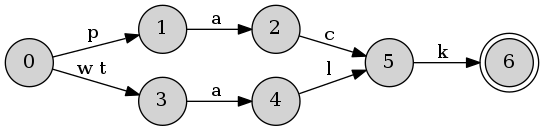

In [2]:
grammar = """
LEXICON Root
pack # ;
talk # ;
walk # ;
"""

compile_lexc(grammar, 'warm_up.fst')
draw_net('warm_up.fst')

There are several points to observe here:
- the format of a word (morpheme) definition line is: `morpheme next_lexicon ;`
    - the `next_lexicon` can be the word end mark `#`
    - word definitions _must_ end with a semicolon (`;`); `LEXICON` lines _must not_
- the basic unit in the FSA is the character, not the whole word
- the FSA is _determinized_ and _minimized_ to save space: see how the states **(3)** and **(5)** and the arc **-k->** are re-used

### Task W2.

Let's add some inflection to the grammar. These are all regular verbs, so they all can receive _-s_, _-ed_, and _-ing_ to form the third person singular, past and gerund forms, respectively. Add these to the second lexicon, and
compile the network again.

Root...3, Infl...Building lexicon...
3
Determinizing...
Minimizing...
Done!
722 bytes. 11 states, 14 arcs, 9 paths.
Writing to file warm_up.fst.

722 bytes. 11 states, 14 arcs, 9 paths.
Writing dot file to warm_up.fst.dot.


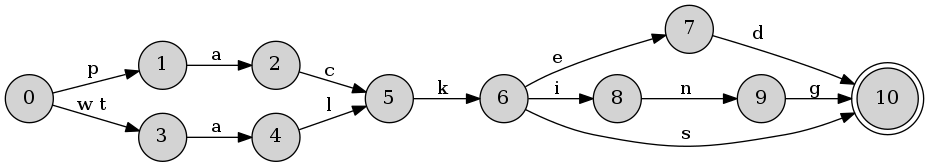

In [5]:
grammar = """
LEXICON Root
! see how the continuation changes to the new LEXICON
! BTW this is a comment
pack Infl ;
talk Infl ;
walk Infl ;

LEXICON Infl
! add the endings here, without the hyphens
s # ;
ed # ;
ing # ;
"""

compile_lexc(grammar, 'warm_up.fst')
draw_net('warm_up.fst')

Now, we can test what words the automaton can recognize in two ways:
- call the `apply_up` or `apply_down` functions with the word form
- use the `print words` foma command

In [6]:
apply_up('warm_up.fst', ['walked', 'talking', 'packs', 'walk'])
execute_commands('load stack warm_up.fst', 'print words')

Applying warm_up.fst up...

walked	walked

talking	talking

packs	packs

walk	+?


Executing commands...

722 bytes. 11 states, 14 arcs, 9 paths.
walking
walked
walks
talking
talked
talks
packing
packed
packs




Uh-oh. Something's wrong: the automaton didn't recognize _walk_. What happened?

The explanation is very simple: now all words in `Root` continue to `Infl`, which requires one of the inflectional endings. See how state **(6)** ceased to be an accepting state.

The solution: replicate the code from [above](#Task-W2.), but also add the "zero morpheme" ending `    # ;` to `Infl`! Make sure that state **(6)** is accepting again and that the recognized words now include the basic form.

### Task W3.

Here we change our automaton to a transducer that lemmatizes words it receives on its bottom tape. Transduction in _lexc_ is denoted by the colon (`:`). Again, copy your grammar below, but replace the contents of `LEXICON Infl` with
```
      # ;
0:s   # ;
0:ed  # ;
0:ing # ;
```
Note that
- only a single colon is allowed on a line
- everything left of it is "up", right is "down"
- the $\varepsilon$ (empty character) is denoted by `0`
- deletion happens on the top, "output" side

Root...3, Infl...Building lexicon...
4
Determinizing...
Minimizing...
Done!
765 bytes. 11 states, 14 arcs, 12 paths.
Writing to file warm_up.fst.

765 bytes. 11 states, 14 arcs, 12 paths.
Writing dot file to warm_up.fst.dot.


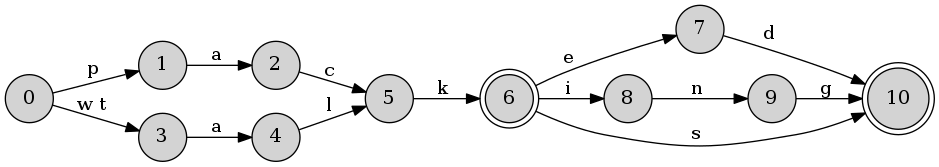

In [11]:
grammar = """
LEXICON Root
! see how the continuation changes to the new LEXICON
! BTW this is a comment
pack Infl ;
talk Infl ;
walk Infl ;

LEXICON Infl
! add the endings here, without the hyphens
      # ;
s   # ;
ed  # ;
ing # ;
"""

compile_lexc(grammar, 'warm_up.fst')
draw_net('warm_up.fst')

Experiment again with `apply_up` and `apply_down`. How do they behave differently?

See how the output of the `print words` command changed. It is also useful to print just the upper or lower tape with `print upper-words` and `print lower-words`.

In [12]:
apply_up('warm_up.fst', ['walked', 'talking', 'packs', 'walk'])
execute_commands('load stack warm_up.fst', 'print words')

Applying warm_up.fst up...

walked	walked

talking	talking

packs	packs

walk	walk


Executing commands...

765 bytes. 11 states, 14 arcs, 12 paths.
walk
walking
walked
walks
talk
talking
talked
talks
pack
packing
packed
packs




## Lexc Intuition

While the ideas behind lexc are very logical, one might need some time to wrap their heads around it. [In this notebook](09_Lexc_Intuition.ipynb), I try to give some advice on how to "think lexc". Do not hesitate to check it out if the tasks below seem to hard. I also provide the solution to [task H1](#Task-H1.) in there, though you are encouraged to come up with your own.

## Hungarian Adjectives

In this exercise, we shall model a subset of the Hungarian nominal paradigm:
- regular adjectives
- vowel harmony
- plurals
- the accusative case
- comparative and superlative forms

The goal is to replicate the output of the Hungarian HFST morphology. We shall learn the following techniques:
- defining lexical automata and tranducers with lexc
- multi-character symbols
- flag diacritics

### Task H1.

We start small with a tiny lexical FSA.
- define a `LEXICON` for the adjectives in the code cell below
- add continuation classes to handle:
  - the plural form (_-ek_)
  - accusative (_-et_)
  
A little help for the latter two: in Hungarian, adjectives (and numerals) are inflected the same way as nouns; this is called the _nominal paradigm_. A simplified schematic would be
```
Root (Plur)? (Case)?
```
Plural is marked by _-k_, and accusative by _-t_. However, if the previous morpheme ends with a consonant (as is the case here), a link vowel is inserted before the _k_ or _t_. Which vowel gets inserted is decided by complicated _vowel harmony_ rules. The adjectives below all contain front vowels only, so the link vowel is **_e_**.

Root...1, adjs...9, plur...2, case...Building lexicon...
2
Determinizing...
Minimizing...
Done!
1.4 kB. 41 states, 49 arcs, 36 paths.
Writing to file h1.fst.

1.4 kB. 41 states, 49 arcs, 36 paths.
Writing dot file to h1.fst.dot.


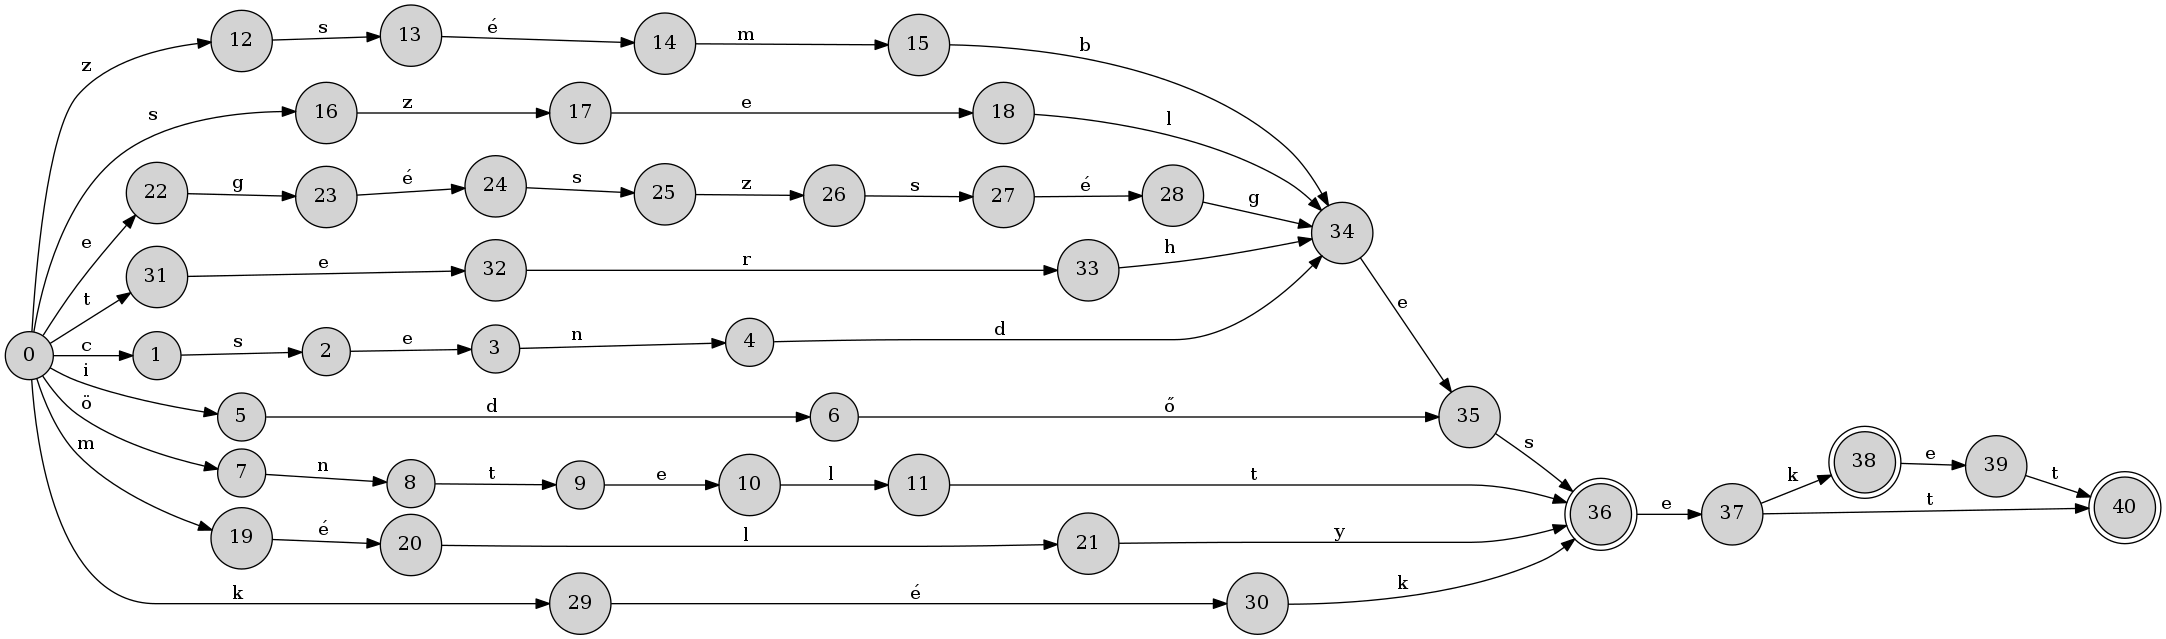

In [17]:
adjectives_1 = """
csendes      plur case ! quiet
egészséges   plur case ! healthy
idős         plur case ! old
kék          plur case ! blue
mély         plur case ! deep
öntelt       plur case ! conceited
szeles       plur case ! windy
terhes       plur case ! pregnant; arduous
zsémbes      plur case ! shrewish
"""

grammar = """
LEXICON Root
    adjs ;
    
LEXICON adjs
csendes      plur ;
egészséges   plur ;
idős         plur ;
kék          plur ;
mély         plur ;
öntelt       plur ;
szeles       plur ;
terhes       plur ;
zsémbes      plur ;

LEXICON plur
0   case ;
ek  case ;

LEXICON case
0  # ;
et #; 
"""

compile_lexc(grammar, 'h1.fst')
draw_net('h1.fst')

### Task H2.

What we have now is a simple (lexical) FSA. In this task, we modify it to have a proper lexical FST that can parse (`apply_up`) surface forms to morphological features and vice versa (`apply_down`).

- Run the words through HFST:
  - Start a new docker bash shell by running `docker exec -it <container name or id> bash`
  - Start HFST by typing `hfst-lookup --cascade=composition /nlp/hfst/hu.hfstol` into the shell
  - Type the words in our FSA (don't forget plural / accusative, e.g. nagyok, finomat) into `hfst-lookup` one-by-one. See what features appear on the upper side (limit yourself to the correct parse, i.e. the one with `[/Adj]`).
- Add the same features to our _lexc_ grammar:
  - remember that you want to keep the surface form in the upper side as well, so e.g. `[/Pl]:ek` won't do. You must
      - either repeat it twice: `ek[/Pl]:ek`
      - or use two lexicons e.g. `Plur` and `PlurTag`, and have `ek` in the first and `[/Pl]:0` in the second
  - all tags, such as `[/Pl]` must be defined in the `Multichar_Symbols` header:
  
```
Multichar Symbols *Symb1* *Symb2* ...

LEXICON Root
...
```
Play around with `apply_up` and `apply_down`. Make sure you covered all tags in the HFST output. (Note: HFST tags color names as `[/Adj|col]`. You don't need to make this distinction in this exercise.)

In [ ]:
grammar = """
"""

compile_lexc(grammar, 'h2.fst')
# apply_up('h2.fst', [])

### Task H2b*.

Copy the `apply` functions and create a `hfst_apply` version of each, which calls _hfst_ instead of _foma_.. Note that _hfst-lookup_ does not support generation. You will probably need `communicate()` to implement function.

_Important: do not start this exercise until you finish all foma-related ones!_

### Task H3.

In the next few exercises, we are going to delve deeper into vowel harmony and techniques to handle it. For now, add the adjectives below to the grammar. In these words, back vowels dominate, so the link vowel for plural and accusative is **_a_**. Create `LEXICON` structures that mirror what you have for the front adjectives to handle the new words.

In [ ]:
adjectives_2 = """
abszurd       ! absurd
bájos         ! charming
finom         ! delicious
gyanús        ! suspicious
okos          ! clever
piros         ! red
száraz        ! dry
zord          ! grim
"""

grammar = """
"""

compile_lexc(grammar, 'h3.fst')
# apply_up('h3.fst', [])

### Task H4.

The previous solution works, but implementing one distinction (_a_/_e_) required us to double the number of lexicons; this clearly doesn't scale. Here, we introduce a more flexible solution: **_flag diacritics_**.

Flag diacritics are (`multichar`!) symbol with a few special properties:
- they have the form `@COMMAND.FEATURE_NAME.FEATURE_VALUE@`, where command is
    - `P`: set
    - `R`: require
    - `D`: XXX
    - `U`: unification (first `P`, then `R`)
- they never appears in the output
- flag diacritics incur some performance overhead, but decrease the size of the FSTs

Add flag diacritics to your grammar. You will want to keep the two adjective types in separate lexicons, e.g.
```
LEXICON Root
@U.HARM.FRONT@  AdjFront ;
@U.HARM.BACK@   AdjBack ;
```
However, the two plural / accusative lexicons can be merged, like so:
```
LEXICON Plur
@U.HARM.FRONT@ek  PlurTag ;
@U.HARM.BACK@ak   PlurTag ;
```
Compile your grammar to see that the network became smaller. Check and see if the new FST accepts the same language as the old one.

In [ ]:
grammar = """
"""

compile_lexc(grammar, 'h4.fst')
# apply_up('h4.fst', [])

### Task H5.

We round up the exercise by adding adjective comparison. Incorporate the following rules into your grammar:
- _Comparative_ forms are marked by **_-bb_**, which takes a link vowel similarly to plural
- The _superlative_ form is marked by the **_leg-_** prefix and **_-bb_**, i.e. a circumfix
- The _exaggerated_ form is the same as the superlative, with any number of **_leges_** coming before _leg_

The full simplified paradigm thus becomes:
```
((leges)* leg)? Root (-bb)? (Plur)? (Case)?
```

Again, the circumfix is best handled with flag diacritics. However, the `U` command probably won't work because its main use is for agreement. Try to implement an `if-else` structure with the other commands!

In [ ]:
grammar = """
"""

compile_lexc(grammar, 'h5.fst')
# apply_up('h5.fst', [])